#### Part2. 심화학습 - AI 사례 실습 
    chp11 - 비데, 정수기 렌탈고객 해지 예측 : (2) EDA

In [1]:
# 환경설정 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time 
import math 
from tqdm import tqdm
from datetime import datetime 
np.random.seed(42)

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   ## 시각화 음수 표현 가능 

In [2]:
train_data = pd.read_parquet("data/train_data.parquet", engine='pyarrow')
test_data = pd.read_parquet("data/test_data.parquet", engine='pyarrow')

train_data.shape, test_data.shape

((55000, 30), (5000, 30))

status
Y    31806
N    23194
Name: count, dtype: int64

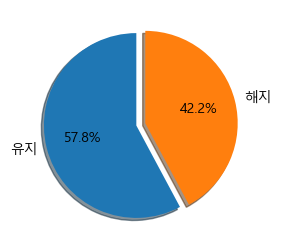

In [14]:
#target값 확인 
target_data = train_data['status'].value_counts()
display(target_data)

plt.figure(figsize=(3,3))
labels = ['유지','해지']
plt.pie(target_data, labels = labels, autopct='%.1f%%', shadow=True, explode=(0,0.1), startangle=90)
plt.show()

In [28]:
# numeric columns --> histogram 
numbers = ['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns 

# 함수 : 모든 수치형 변수에 대해 분포 생성 
def make_kdeplot(df, num_cols, label): 
    col_cnt = 4
    graph_size = 5
    num = len(num_cols)
    print('컬럼수 = ', num)

    plt.rcParams['figure.figsize'] = (col_cnt*graph_size, math.ceil(num/col_cnt)*graph_size)

    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i = 0
    for column in tqdm(num_cols): 
        sns.kdeplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])        
        ax[int(i/col_cnt)][i%col_cnt].set_title('[' + column + ']')
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
        i = i+1
    plt.show()
    #plt.rcParams['figure.figsize'] = (3,3)    ## 사이즈 원상복귀 

컬럼수 =  22


100%|██████████| 22/22 [00:05<00:00,  3.89it/s]


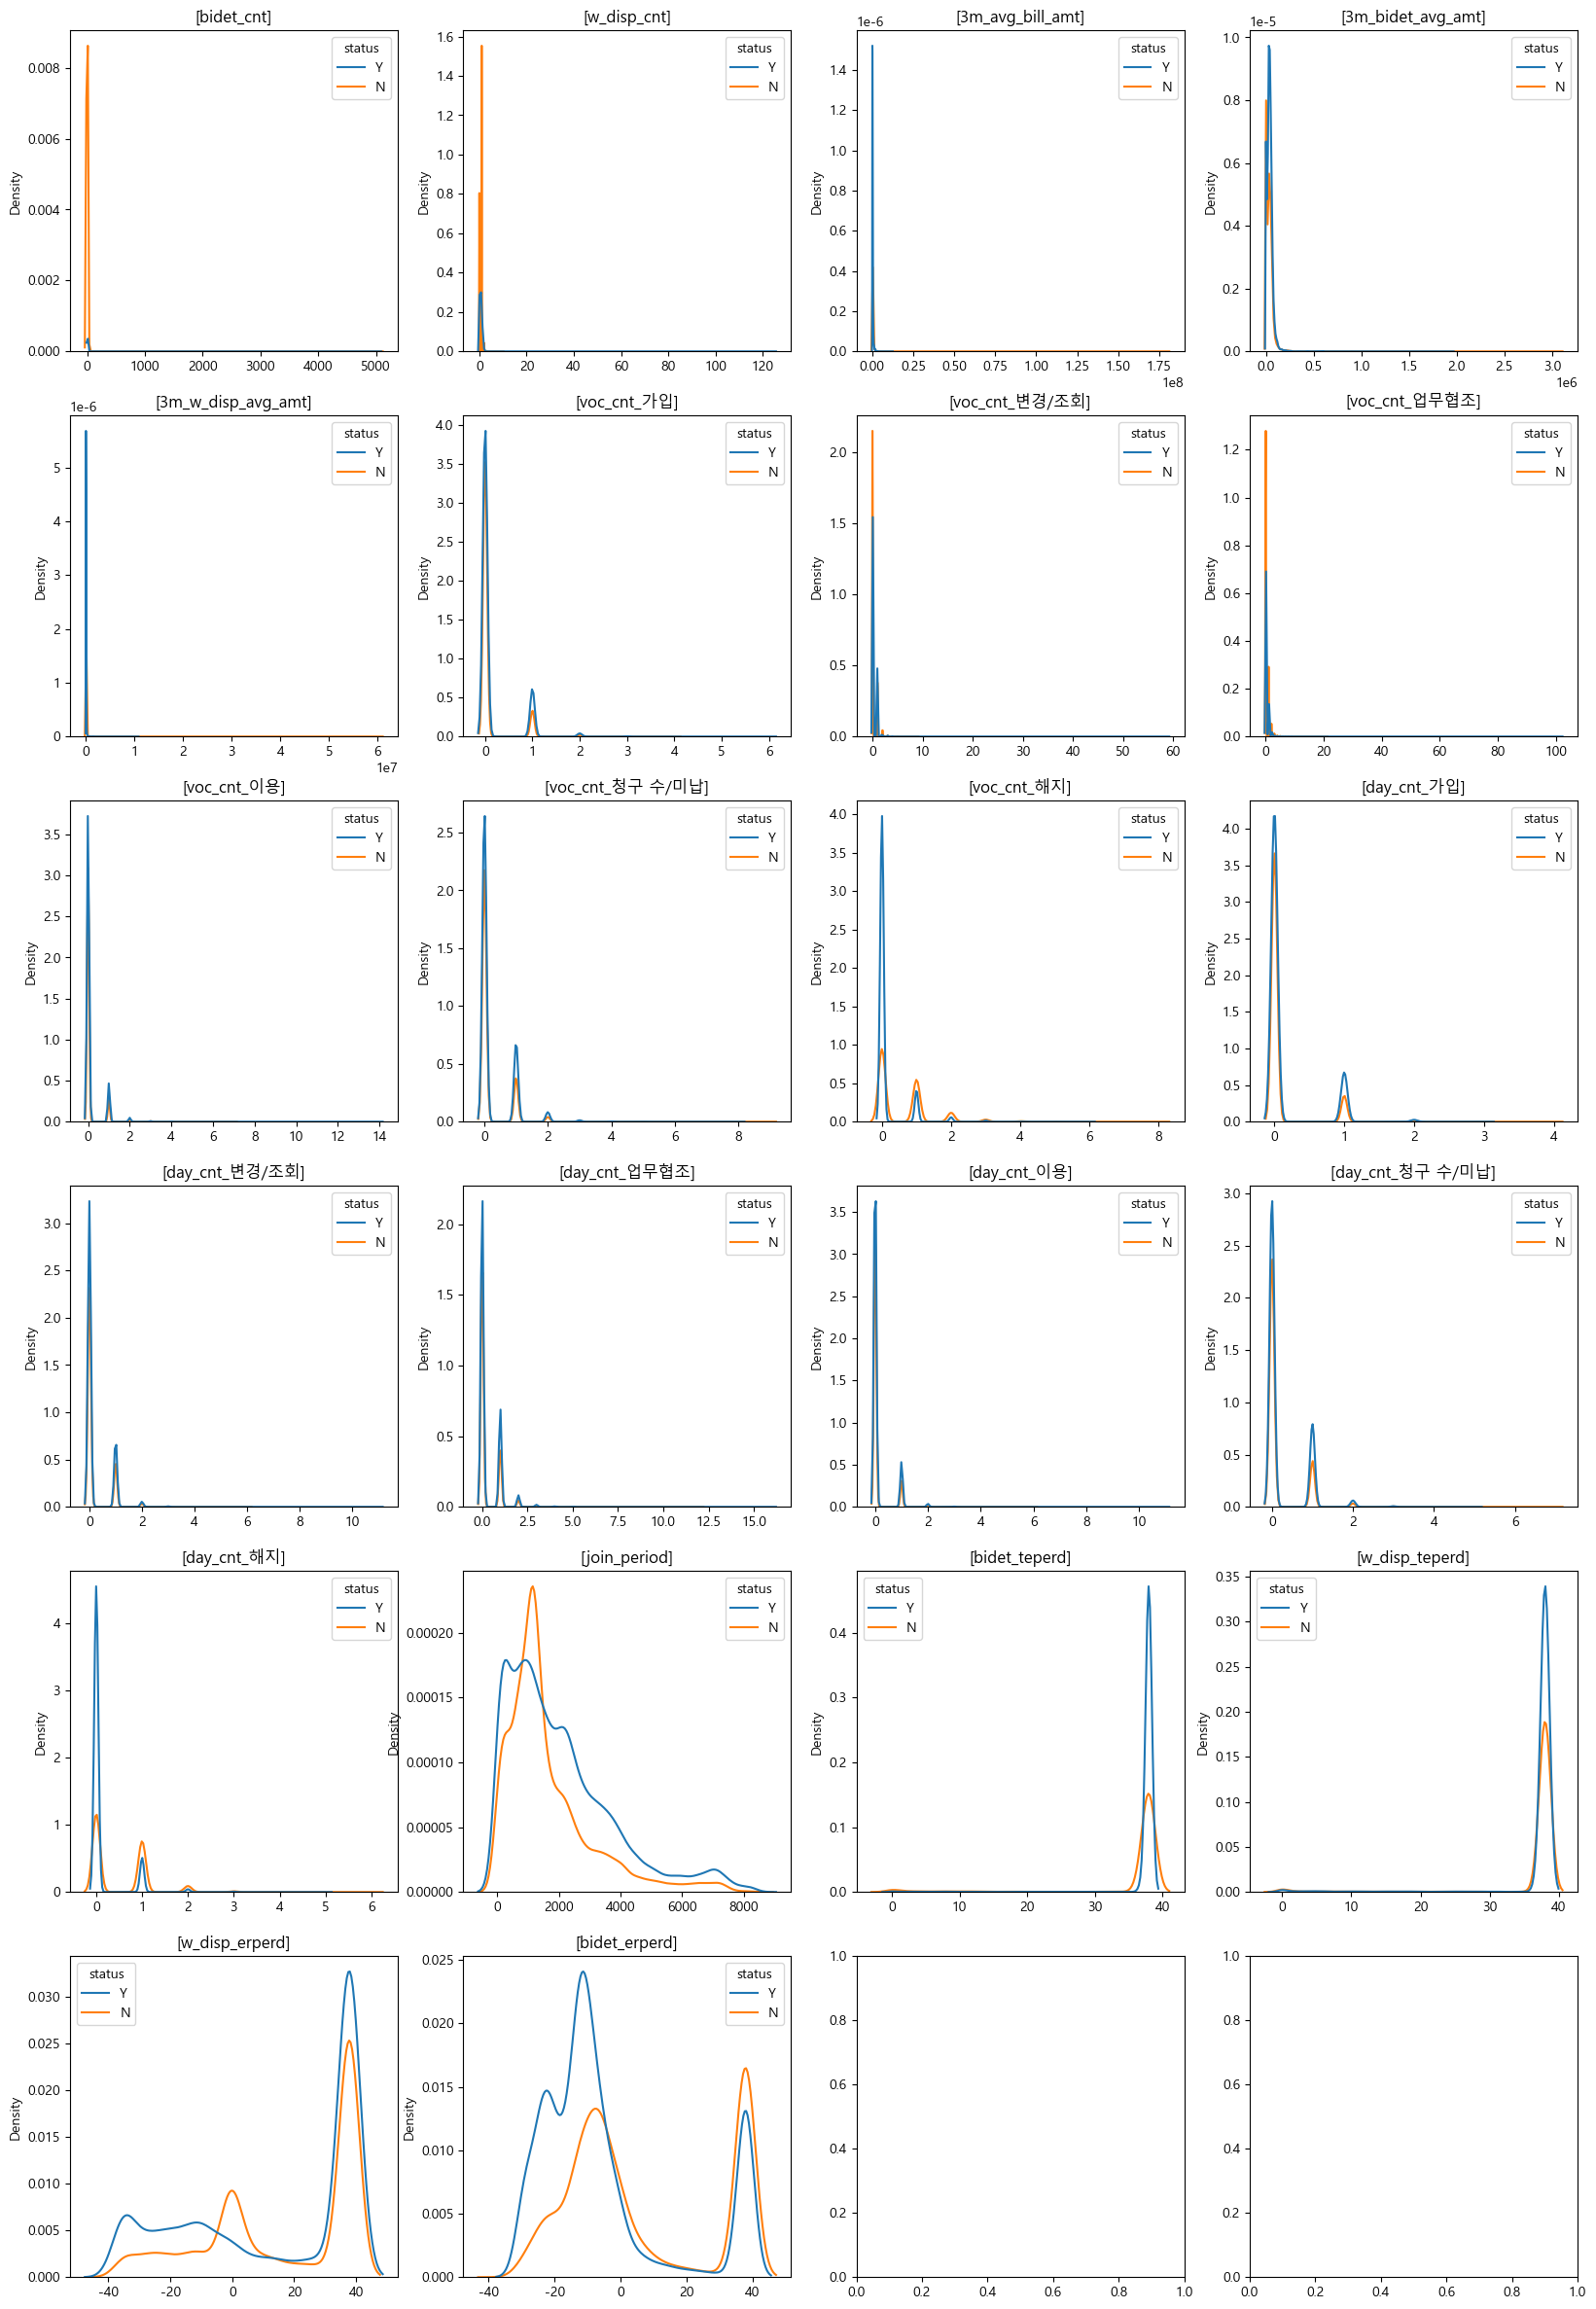

In [29]:
make_kdeplot(train_data, num_cols, 'status')

In [22]:
# 이상치 제거 : 현업 노하우에 따라 각 컬럼의 최대값이 20이상인 컬럼은 제거 
outlier_cols = train_data.describe().loc['max'][train_data.describe().loc['max']>20].index.tolist()
outlier_cols

['bidet_cnt',
 'w_disp_cnt',
 '3m_avg_bill_amt',
 '3m_bidet_avg_amt',
 '3m_w_disp_avg_amt',
 'voc_cnt_변경/조회',
 'voc_cnt_업무협조',
 'join_period',
 'bidet_teperd',
 'w_disp_teperd',
 'w_disp_erperd',
 'bidet_erperd']

In [30]:
# 이상치 기준이 되는 upperfence와 lowerfence지점의 위치 값을 계산하고 반환하기
def outliers_iqr(df,column,uorl,upper=75,lower=25,factor=1.5):
    q1,q3 = np.percentile(df[column],[lower,upper]) # 1분위 수, 3분위 수 구하기
    iqr=q3-q1
    if uorl=='l': # l이면 하한, u이면 상한
        return (q1-(iqr*factor))
    elif uorl=='u':
        return (q3+(iqr*factor))   

# 이상치(upperfence 초과)를 upperfence로 대체하는 함수, lower는 고려하지 않음
def replace_outlier(df,cols,upper=75,lower=25,factor=1.5):
    for column in cols:
        upperfence=outliers_iqr(df,column,'u',upper,lower,factor)
        df[column]=df[column].apply(lambda x: x if x <=upperfence else upperfence) 

In [31]:
train_data_del_outlier = train_data.copy()
replace_outlier(train_data_del_outlier, outlier_cols, factor=1.5)    ## factor : iqr에서 Q1, Q3의 몇배를 outlier로 취급할 것인지 지정 (일반적으로 1.5배)

컬럼수 =  22


100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


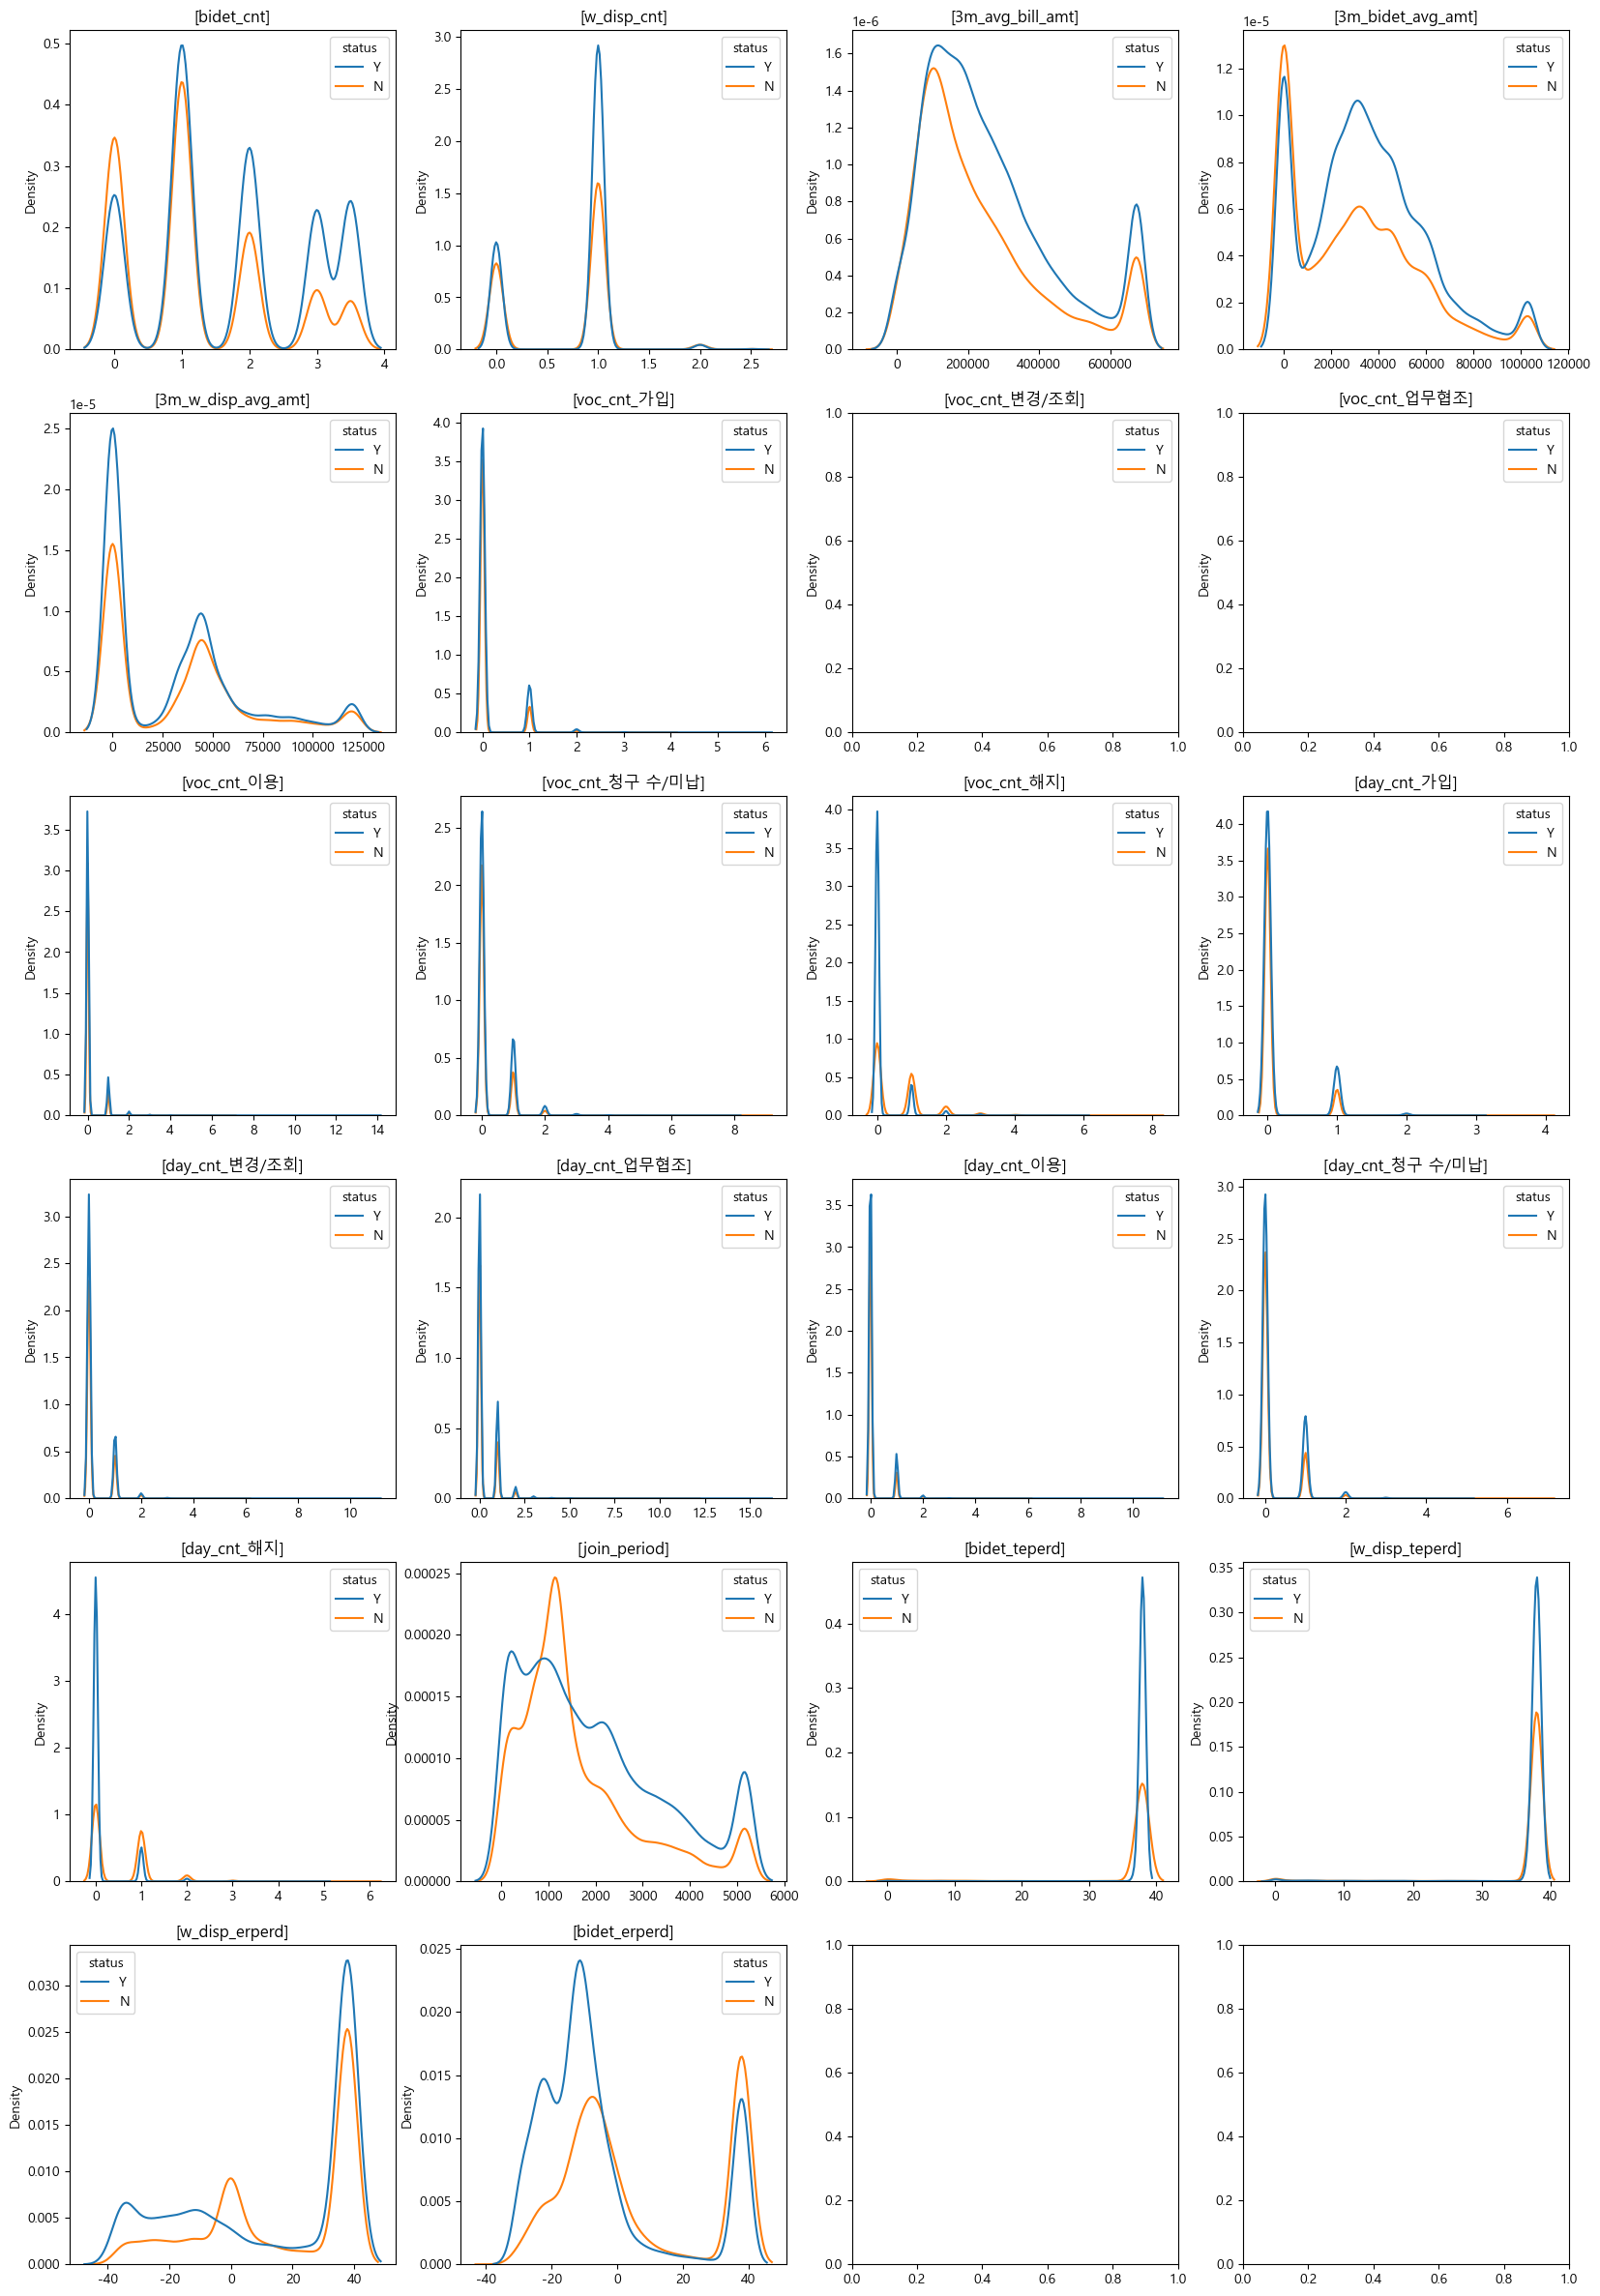

In [32]:
make_kdeplot(train_data_del_outlier, num_cols, 'status')

- join_period : 3년 약정(약 1100일)기간 경과시, 해지가 급격히 증가 
- voc_cnt해지, day_cnt해지 : 해지관련 voc 발생시, 해지가 급격히 증가 
- bidet_erperd : 정수기는 약정 만료일 근처에서 해지가 증가하는데 반해, 비데는 만료일 전에 해지 많음(초기 불만?)

In [ ]:
# point plot : Y/N의 평균 비교 ~ 어떤 변수가 유지/해지에 정/역방향의 영향을 주는지, 또는 상관없는 변수인지 ... 
def make_pointplot(df,num_cols,label):       
    num=len(num_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)
    
    # 그려야할 전체 그래프의 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size) 
    
    # 그려야할 각각의 그래프의 위치 정하기   
    fig, ax = plt.subplots(ncols=col_cnt,nrows=math.ceil(num/col_cnt)) 
    i=0          
    for column in tqdm(num_cols):
        sns.pointplot(data=df,y=column,x=label,ax=ax[int(i/col_cnt)][i%col_cnt])    
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')  # 칼럼명을 제목으로 붙이기
        ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')             # y축의 이름을 공란으로 하기
        i=i+1

    plt.show()

대상 칼럼수: 22


100%|██████████| 22/22 [00:09<00:00,  2.36it/s]


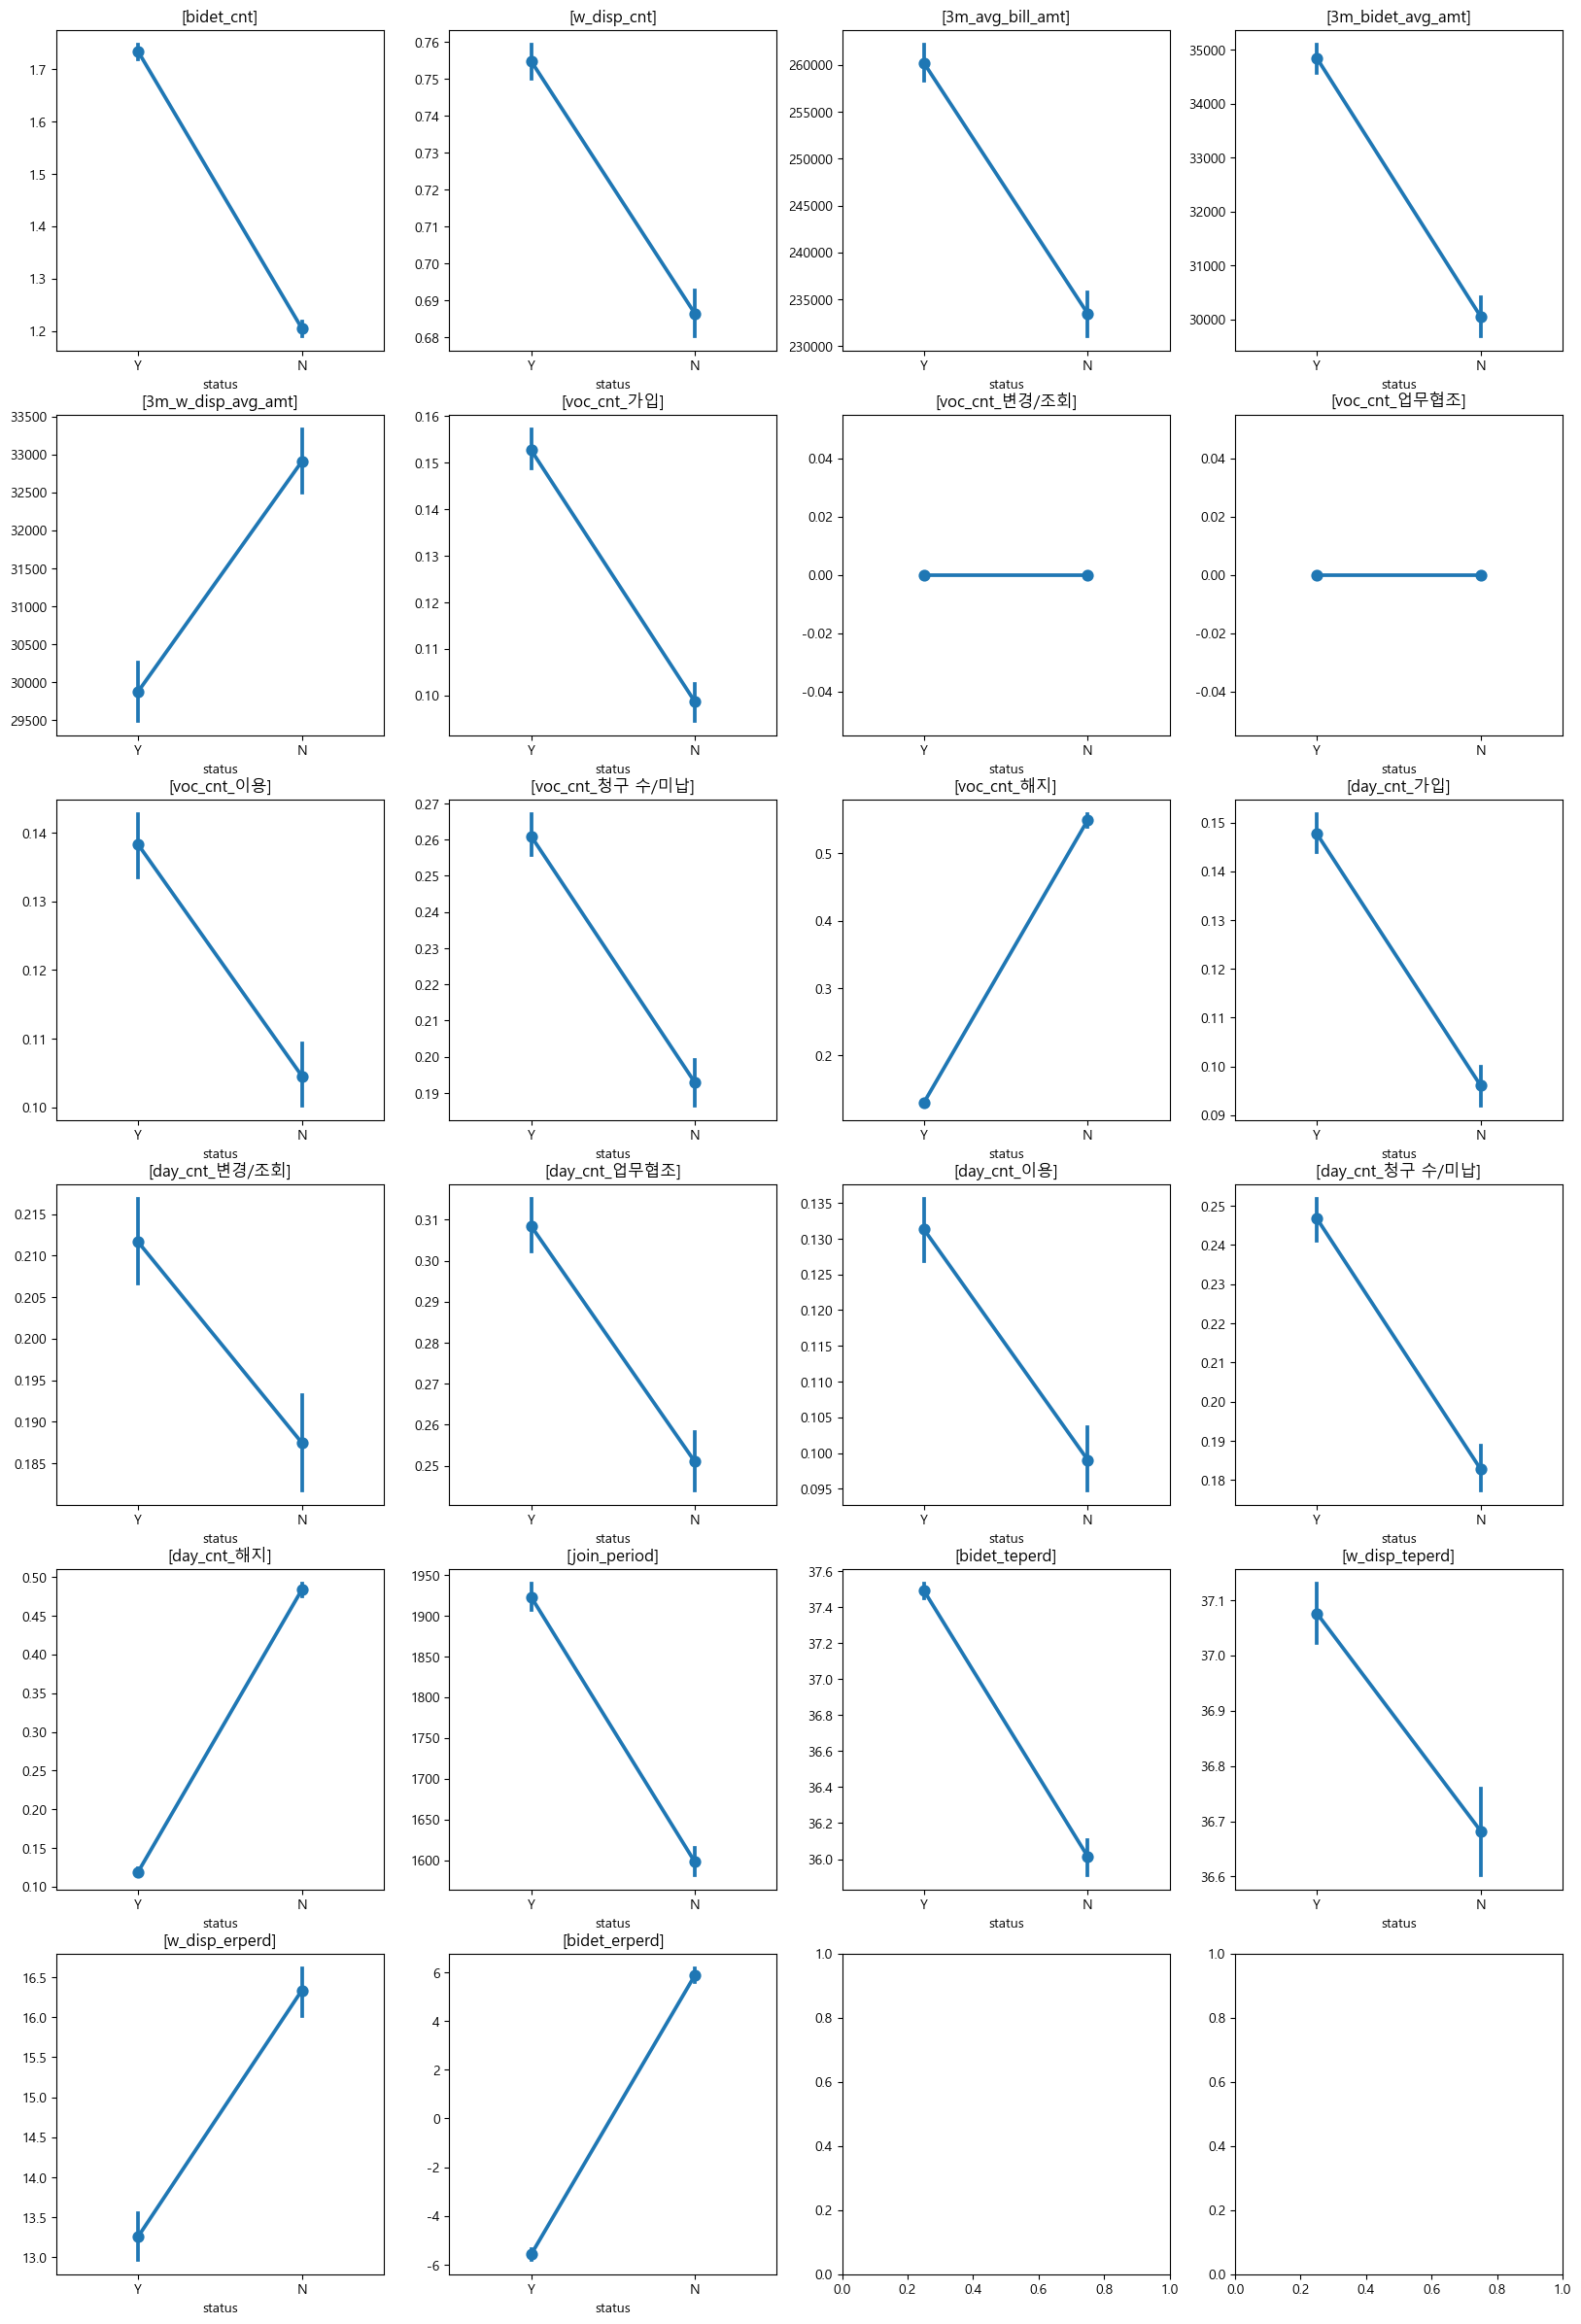

In [34]:
make_pointplot(train_data_del_outlier,num_cols,'status')

In [38]:
# 범주형 컬럼 분석 
obj_cols = train_data.select_dtypes('object').columns
print(obj_cols)

def make_count_plot(df, obj_cols, label): 
    num = len(obj_cols)
    col_cnt = 4
    graph_size = 5

    plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    
    i = 0
    for column in obj_cols: 
        sns.countplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')  # 칼럼명을 제목으로 붙이기
        ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')             # y축의 이름을 공란으로 하기
        i=i+1
    plt.show()

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')


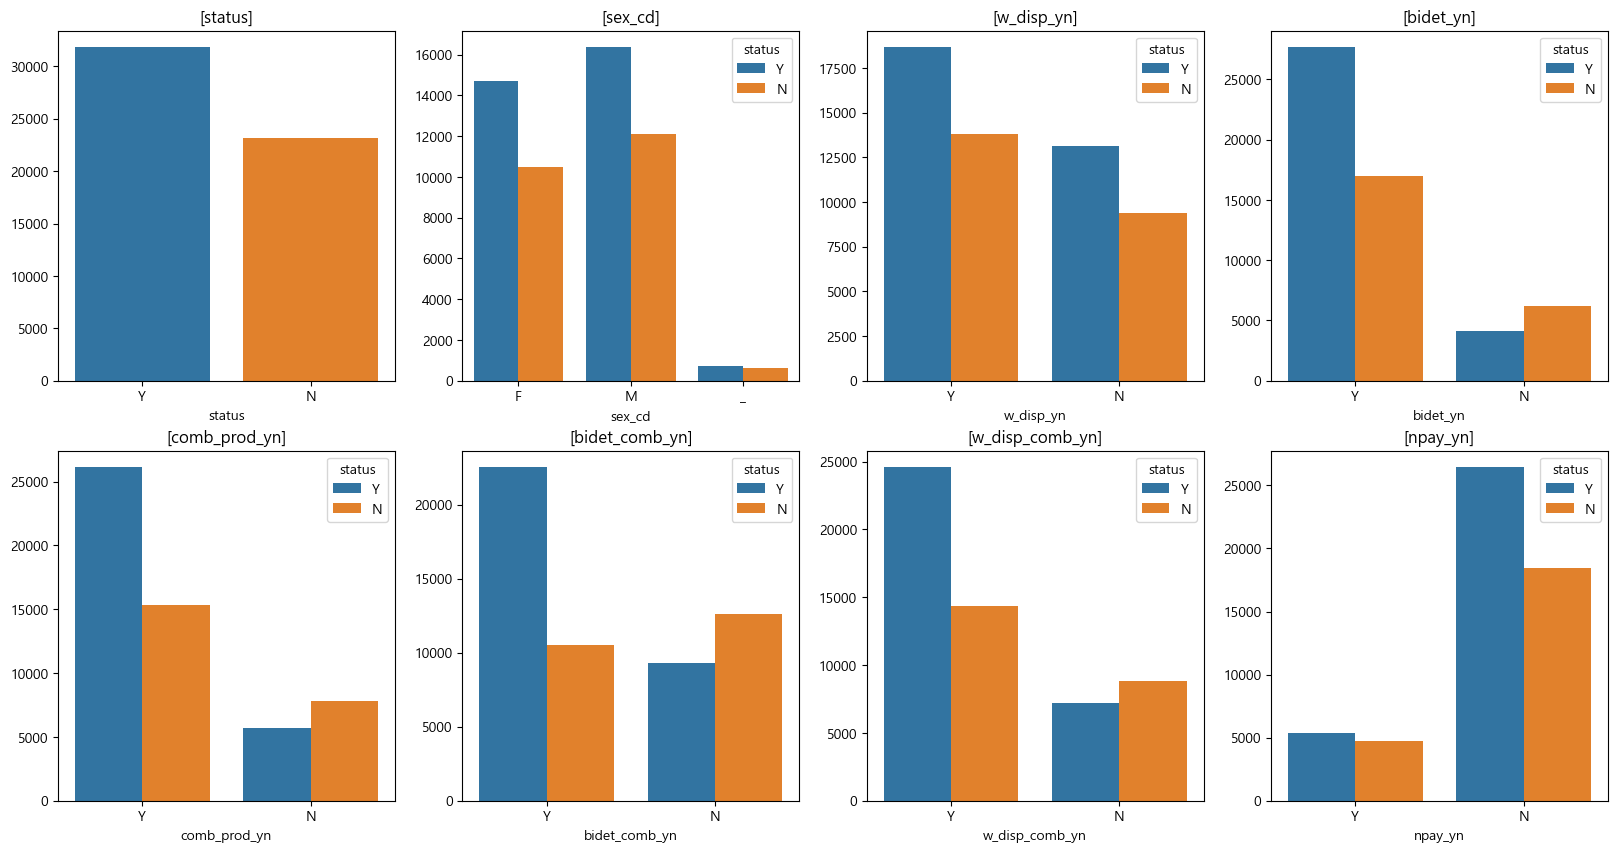

In [39]:
make_count_plot(train_data, obj_cols, 'status')

- 정수기 미가입 보다 비데 미가입시 해지비율이 더 높다 
- 결합상품 미가입 고객의 해지 비율이 더 높다 